**Installations**

In [1]:
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install scikit-learn
!pip install tensorflow
!pip install skfeature-chappers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


**Imports**

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
import keras 
from keras import layers
from skfeature.function.similarity_based import fisher_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model

**Loading Datasets**

In [3]:
df = pd.read_csv("../Datasets/energy_efficiency.csv")

df.head()

,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
0,0.98,514.5,294.0,110.25,7.0,2.0,0.0,0.0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3.0,0.0,0.0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4.0,0.0,0.0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5.0,0.0,0.0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2.0,0.0,0.0,20.84,28.28


**Checking for duplicates**

In [5]:
df.duplicated().sum()

np.int64(0)

**Checking for missing values**

In [9]:
df.isna().sum()

relative_compactness         0
surface_area                 0
wall_area                    0
roof_area                    0
overall_height               0
orientation                  0
glazing_area                 0
glazing_area_distribution    0
heating_load                 0
cooling_load                 0
dtype: int64

**Define X and y -variables**

In [7]:
X = df.drop(["heating_load", "cooling_load"], axis=1)
y = df[["heating_load", "cooling_load"]]

**Correlation Matrix**

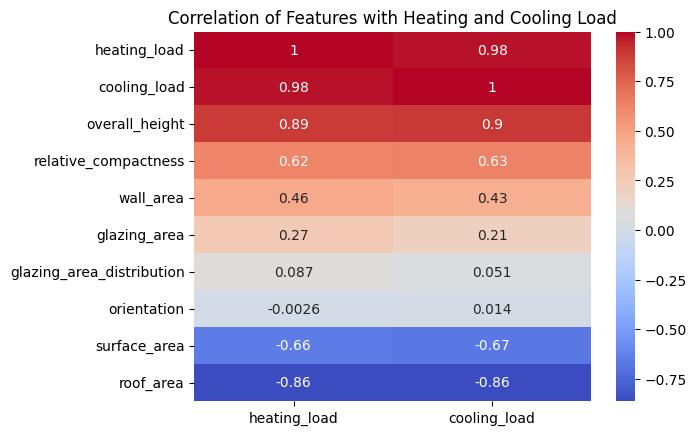

In [8]:
corr = df.corr()
sns.heatmap(corr[['heating_load', 'cooling_load']].sort_values(by='heating_load', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation of Features with Heating and Cooling Load')
plt.show()

We can see that overall_height and roof area are the most influential features overall and orientation and glazing_area_distribution are negligible

**Fisher's score**

c:\Users\stsaa\Desktop\Deep-Learning\.venv\Lib\site-packages\skfeature\function\similarity_based\fisher_score.py:59: RuntimeWarning: divide by zero encountered in divide
  score = 1.0 / lap_score - 1


<Axes: >

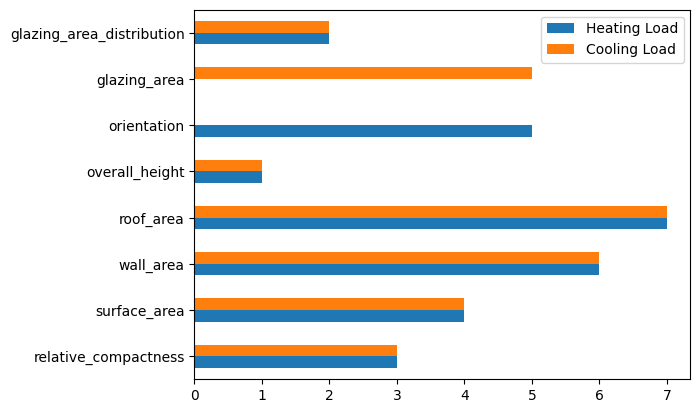

In [ ]:
heating_scores = fisher_score.fisher_score(X.values, y["heating_load"].values)
cooling_scores = fisher_score.fisher_score(X.values, y["cooling_load"].values)
feat_importances = pd.DataFrame({
    'Heating Load': heating_scores,
    'Cooling Load': cooling_scores
}, index=X.columns)
feat_importances.plot(kind='barh')


This tells us a few important things such as roof area might be the most influential feature which makes sense as bigger the area more energy needed for both heating and cooling. Secondly, Glazing area seems to be an important feature for cooling which makes sense as more glasses allow more sunlight to pass and that would heat house up especially in summers increasing cooling load.and in same sense orientation matters more in heating as in winters sunlight is limited so orienation has an effect. Surprsingly, overall height is not very significant here I'm presuming its because roof area and surface area are covering the volume making height redundant.

**SelectKBest-score**

In [30]:
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

chi2_heating = SelectKBest(score_func=chi2, k=len(X_cat.columns))
chi2_heating.fit(X_cat, y["heating_load"].astype(int))
heating_scores = chi2_heating.scores_

chi2_cooling = SelectKBest(score_func=chi2, k=len(X_cat.columns))
chi2_cooling.fit(X_cat, y["cooling_load"].astype(int))
cooling_scores = chi2_cooling.scores_

f_scores = pd.DataFrame({
    'Feature': X_cat.columns,
    'Heating Load Score': heating_scores,
    'Cooling Load Score': cooling_scores
})
f_scores = f_scores.sort_values(by='Heating Load Score', ascending=False)
pd.options.display.float_format = '{:.2f}'.format
print(f_scores)


                     Feature  Heating Load Score  Cooling Load Score
3                  roof_area             8054.34             8282.48
1               surface_area             6871.38             6916.86
2                  wall_area             2294.18             1649.80
4             overall_height              579.71              600.71
7  glazing_area_distribution              106.14              105.54
5                orientation                3.05                6.97
0       relative_compactness                 NaN                 NaN
6               glazing_area                 NaN                 NaN


We can observe that roof are and surface area are consistently the most influential features which is logical.

**train/test/validation -split**

In [31]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

**Neural Network**

In [77]:
input_shape = (X_train.shape[1],)

mc = ModelCheckpoint('best_model_ann_regression1.keras', monitor='val_loss', mode='min', save_best_only=True)
callback_list = [mc]

inputs = keras.Input(shape=input_shape)
x = layers.BatchNormalization()(inputs)
x = layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-3))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dense(8, activation="relu")(x)

heating_output = layers.Dense(1, name="heating_load")(x)
cooling_output = layers.Dense(1, name="cooling_load")(x)

model = keras.Model(inputs=inputs, outputs=[heating_output, cooling_output])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss='mse')
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8)         │         32 │ input_layer_4[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 128)       │      1,152 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 64)        │      8,256 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64)        │          0 │ dense_17[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 32)        │      2,080 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32)        │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 16)        │        528 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 8)         │        136 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ heating_load        │ (None, 1)         │          9 │ dense_20[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cooling_load        │ (None, 1)         │          9 │ dense_20[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,202 (47.66 KB)

 Trainable params: 12,186 (47.60 KB)

 Non-trainable params: 16 (64.00 B)

In [78]:
model.fit(X_train, [y_train["heating_load"], y_train["cooling_load"]], epochs=1200,
        validation_data=(X_val, [y_val["heating_load"], y_val["cooling_load"]]), batch_size=32,
        callbacks=callback_list, verbose=1
)

Epoch 1/1200


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - cooling_load_loss: 713.1511 - heating_load_loss: 601.3891 - loss: 1311.2664 - val_cooling_load_loss: 614.2645 - val_heating_load_loss: 344.6740 - val_loss: 909.8665
Epoch 2/1200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - cooling_load_loss: 702.4143 - heating_load_loss: 561.2082 - loss: 1264.8402 - val_cooling_load_loss: 562.2441 - val_heating_load_loss: 206.2661 - val_loss: 726.5762
Epoch 3/1200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - cooling_load_loss: 681.8109 - heating_load_loss: 478.9449 - loss: 1155.9349 - val_cooling_load_loss: 455.9361 - val_heating_load_loss: 105.2359 - val_loss: 531.0159
Epoch 4/1200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - cooling_load_loss: 610.4254 - heating_load_loss: 327.8820 - loss: 936.9232 - val_cooling_load_loss: 263.4811 - val_heating_load_loss: 181.1342 - val_loss: 434.2049
Epoch 5/1200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cooling_load_loss: 435.7868 - heating_load_loss: 138.1013 - loss: 573.0391 - val_co

<Axes: >

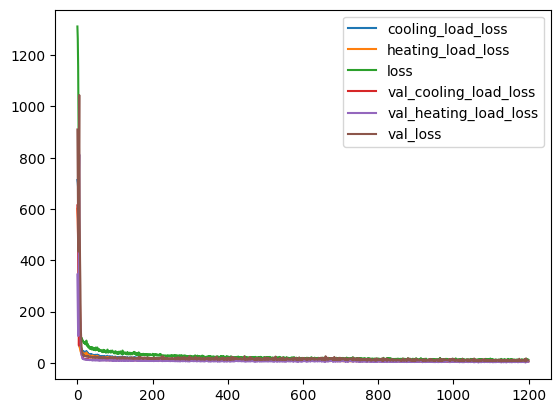

In [79]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [99]:
model = load_model("../ANN Regresion/best_model_ann_regression1.keras")

In [100]:
print("Test data evaluation:")
print(model.evaluate(X_test, [y_test["heating_load"], y_test["cooling_load"]], verbose=0))

print("\nTrain data evaluation:")
print(model.evaluate(X_train, [y_train["heating_load"], y_train["cooling_load"]], verbose=0))


Test data evaluation:
[6.5467634201049805, 2.1130247116088867, 4.803991317749023]

Train data evaluation:
[5.821857452392578, 1.935478925704956, 3.8628010749816895]


In [92]:
test_predictions = model.predict(X_test)

heating_pred = test_predictions[0].flatten()
cooling_pred = test_predictions[1].flatten()

pred_df = pd.DataFrame({
    "True Heating Load": y_test["heating_load"].values,
    "Pred Heating Load": heating_pred,
    "True Cooling Load": y_test["cooling_load"].values,
    "Pred Cooling Load": cooling_pred
})

pred_df.head()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


,True Heating Load,Pred Heating Load,True Cooling Load,Pred Cooling Load
0,14.50,13.74,17.12,16.30
1,31.64,29.59,36.86,31.23
2,15.12,14.88,15.95,16.63
3,32.82,30.55,32.78,31.23
4,28.15,27.34,29.79,28.61


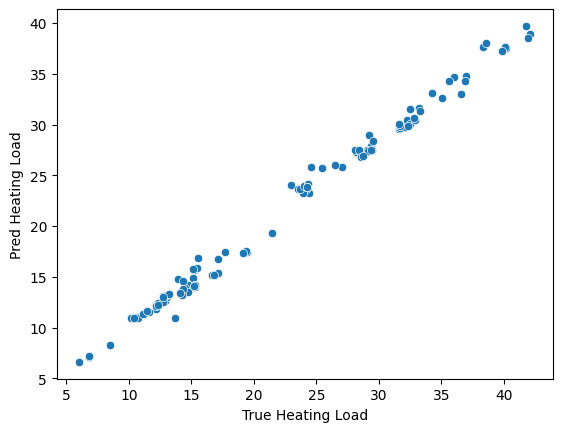

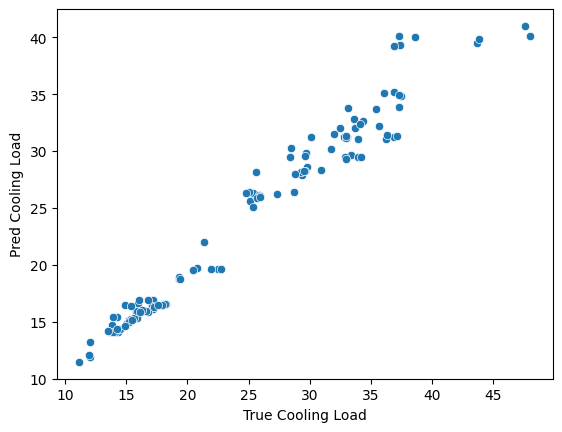

In [93]:
sns.scatterplot(x='True Heating Load', y='Pred Heating Load', data=pred_df)
plt.show()
sns.scatterplot(x='True Cooling Load', y='Pred Cooling Load', data=pred_df)
plt.show()

In [94]:
from sklearn import metrics
import numpy as np

heating_true = y_test["heating_load"].values
cooling_true = y_test["cooling_load"].values
heating_pred = test_predictions[0].flatten()
cooling_pred = test_predictions[1].flatten()

print("Heating Load Metrics:")
print("MAE:", round(metrics.mean_absolute_error(heating_true, heating_pred), 2))
print("MSE:", round(metrics.mean_squared_error(heating_true, heating_pred), 2))
print("RMSE:", round(np.sqrt(metrics.mean_squared_error(heating_true, heating_pred)), 2))
print("R²:", round(metrics.r2_score(heating_true, heating_pred), 2))
print("Explained Variance:", round(metrics.explained_variance_score(heating_true, heating_pred), 2))

print("\nCooling Load Metrics:")
print("MAE:", round(metrics.mean_absolute_error(cooling_true, cooling_pred), 2))
print("MSE:", round(metrics.mean_squared_error(cooling_true, cooling_pred), 2))
print("RMSE:", round(np.sqrt(metrics.mean_squared_error(cooling_true, cooling_pred)), 2))
print("R²:", round(metrics.r2_score(cooling_true, cooling_pred), 2))
print("Explained Variance:", round(metrics.explained_variance_score(cooling_true, cooling_pred), 2))


Heating Load Metrics:
MAE: 1.11
MSE: 2.03
RMSE: 1.42
R²: 0.98
Explained Variance: 0.99

Cooling Load Metrics:
MAE: 1.49
MSE: 4.5
RMSE: 2.12
R²: 0.95
Explained Variance: 0.96


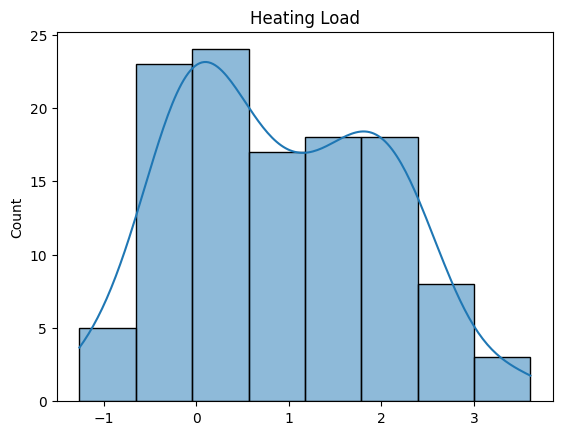

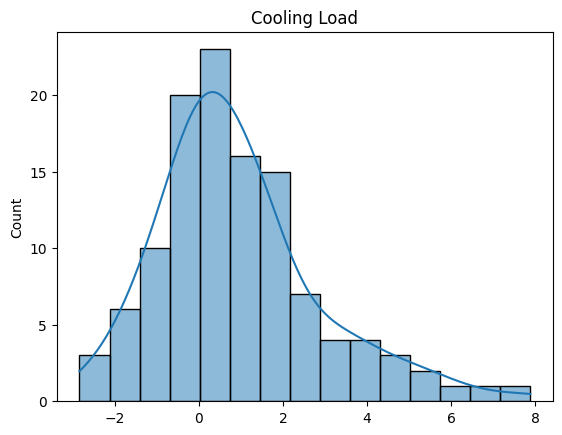

In [95]:
sns.histplot(heating_true - heating_pred, kde=True)
plt.title("Heating Load")
plt.show()

sns.histplot(cooling_true - cooling_pred, kde=True)
plt.title("Cooling Load")
plt.show()

In [96]:
df.tail()


,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
763,0.64,784.00,343.00,220.50,3.50,5.00,0.40,5.00,17.88,21.40
764,0.62,808.50,367.50,220.50,3.50,2.00,0.40,5.00,16.54,16.88
765,0.62,808.50,367.50,220.50,3.50,3.00,0.40,5.00,16.44,17.11
766,0.62,808.50,367.50,220.50,3.50,4.00,0.40,5.00,16.48,16.61
767,0.62,808.50,367.50,220.50,3.50,5.00,0.40,5.00,16.64,16.03


In [97]:
tester_row = {
    'relative_compactness': 0.64,
    'surface_area': 784.0,
    'wall_area': 343.0,
    'roof_area': 220.5,
    'overall_height': 3.5,
    'orientation': 5.0,
    'glazing_area': 0.4,
    'glazing_area_distribution': 5.0
}

tester_row = pd.DataFrame([tester_row])


In [98]:
import pandas as pd
import numpy as np

# Ensure numeric types
tester_row = tester_row.astype(np.float32)

# Make prediction
result = model.predict(tester_row)

# Extract both outputs
heating_load = result[0][0][0]
cooling_load = result[1][0][0]

print(f"Predicted Heating Load: {heating_load:.2f}")
print(f"Predicted Cooling Load: {cooling_load:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Heating Load: 17.25
Predicted Cooling Load: 19.83


In [102]:
model.save("ann_regression_model.keras")